# Baseline Analysis of the FFT Data

Using the FFT data we have, we can perform baseline analysis for the experiments we set up:
- real FFT data, PCA performed on the SEEG contacts
- real FFT data, inverse-gain matrix applied on the SEEG space to project to brain-region space
- augmented data
- 

In [2]:
import numpy as np
import os
import pandas as pd
import scipy
import sklearn
import sys
from time import time
np.random.seed(1234567)

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    f1_score, confusion_matrix, accuracy_score
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# import data handler for the fft type data
sys.path.append('../../')
from dnn.processing.util import DataHandler
    
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Test Baseline on Real Data


In [3]:
# real image data dir
datadir = '/Volumes/ADAM LI/pydata/output_fft/asimages/realtng/'

datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))

# PCA
numcomp = 50
sklearn_pca = PCA(n_components=numcomp)

# data handler
datautil = DataHandler()

print("Number of real data - fft files: ", len(datafiles))
print("The data directory we grabbed from: ", datadir)
print(os.getcwd())

Number of real data - fft files:  17
The data directory we grabbed from:  /Volumes/ADAM LI/pydata/output_fft/asimages/realtng/
/Users/adam2392/Documents/dnn-unsupervised/notebooks/baselines


In [4]:
# load datafiles into features
for idx, datafile in enumerate(datafiles):
    data = np.load(datafile)
    image_tensor = data['image_tensor']
    metadata = data['metadata'].item()
    
    # load in the metadata
    chanlabels = metadata['chanlabels']
    seeg_xyz = metadata['seeg_xyz']
    ylabels = metadata['ylabels']
    samplerate = metadata['samplerate']
    timepoints = metadata['timepoints']
    
    filename = datafile.split('/')[-1]
    patient = '_'.join(filename.split('_')[0:1])
    print(filename)
    
    # create the X / y data
    if idx is 0:
        Xdata = image_tensor.reshape(len(ylabels),-1)
        ydata = ylabels
        patients = [patient] * len(ylabels)
    else:
        Xdata = np.concatenate((Xdata, image_tensor.reshape(len(ylabels),-1)), axis=0)
        ydata = np.concatenate((ydata, ylabels), axis=0)
        patients = np.concatenate((patients, [patient]*len(ylabels)))
        
print(Xdata.shape)
print(ydata.shape)

id001_ac_absence_fftmodel.npz
id001_ac_comp_fftmodel.npz
id001_ac_sz2_fftmodel.npz
id001_ac_sz2_2_fftmodel.npz
id001_ac_sz3_fftmodel.npz
id002_cj_sz1_fftmodel.npz
id002_cj_sz2_fftmodel.npz
id002_cj_sz3_fftmodel.npz
id002_cj_sz4_fftmodel.npz
id002_cj_sz5_fftmodel.npz
id002_cj_sz6_fftmodel.npz
id008_gc_sz2_fftmodel.npz
id008_gc_sz3_fftmodel.npz
id010_js_sz1_fftmodel.npz
id011_ml_sz2_fftmodel.npz
id012_pc_sz1_fftmodel.npz
id013_pg_sz1_fftmodel.npz
(47247, 4096)
(47247, 1)


[0.69208121 1.80153283]
Baseline testing prediction of all seizure:  1.0


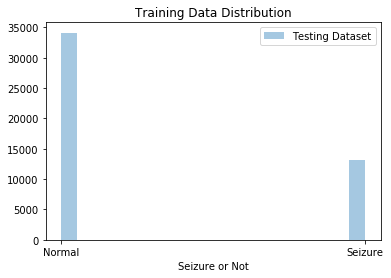

In [5]:
inverty = 1 - ydata
ydata = np.concatenate((inverty, ydata), axis=1)

class_weight = sklearn.utils.compute_class_weight('balanced',
                                        np.unique(ydata).astype(int),
                                        np.argmax(ydata, axis=1))
print(class_weight)

# plot the data distribution of binary labels
plt.figure()
sns.distplot(np.argmax(ydata, axis=-1), kde=False, axlabel='Seizure or Not', label='Testing Dataset')
ax=plt.gca()
ax.set_title('Training Data Distribution')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal', 'Seizure'])
ax.legend()

print("Baseline testing prediction of all seizure: ", np.sum(ydata)/len(ydata))

In [6]:
def splitpatdata(listofpats, Xdata, ydata):
    # list of pats
    uniquepats = np.unique(listofpats)
    
    ind = 0
    while 1:
        if ind == len(uniquepats):
            break
            
        # get indices of this pat
        pat = uniquepats[ind]
        print(pat)
        patinds = np.where(listofpats == pat)[0]
        otherinds = np.where(listofpats != pat)[0]
        
        # create generator
        Xtest = Xdata[patinds,...]
        ytest = ydata[patinds,...]
        
        Xtrain = Xdata[otherinds,...]
        ytrain = ydata[otherinds,...]
        yield Xtrain, ytrain, Xtest, ytest
        ind += 1

In [7]:
datasplitter = splitpatdata(listofpats=patients, Xdata=Xdata, ydata=ydata)

# print(datasplitter)
# for idx, batch in enumerate(datasplitter):
#     print(idx)
#     Xpat, ypat, Xtest, ytest = batch
#     print(Xpat.shape)
#     print(ypat.shape)
#     print(Xtest.shape)
#     print(ytest.shape)
#     if idx == 2:
#         break

In [8]:
randstate = 42 # for reproducability
# run random forest classifier with loo on patient side
model_params = {'max_depth': [5,10,15], 
                'n_estimators':[10,50,100], 
                'max_features': [1,2,5],
                'oob_score': True,
               'random_state': randstate}
model_params = {'max_depth': 5, 
                'n_estimators':100, 
                'max_features': 4,
                'oob_score': True,
               'random_state': randstate}
clf_rf = RandomForestClassifier(**model_params)

In [19]:
# model_params = {
#     'Cs': np.logspace(-4, 4, 3),
#     'penalty': ['l1', 'l2'],
#     'random_state': randstate
# }
model_params = {
    'C': 10e4,
    'penalty': 'l1',
    'random_state': randstate
}

clf_lr = LogisticRegression(**model_params)

In [21]:
model_params = {
    'C': 10e-1,
    'kernel': 'linear',
    'random_state': randstate
}

clf_svc = SVC(**model_params)

# 2) Run Models of Real Data

- Random Forest
- SVC (if possible...?)
- Logistic Regression
- Extra Trees Classifier

id001


Showing iteration %d 0
Out-of-bag score estimate: 0.868
Mean accuracy score: 0.756
F1 score: 0.8609205188561126
Recall: 0.9976784677887406
Precision: 0.7571353065539113

 clasification report:
              precision    recall  f1-score   support

          0       0.35      0.00      0.01      2768
          1       0.76      1.00      0.86      8615

avg / total       0.66      0.76      0.65     11383


 confusion matrix:
 [[  11 2757]
 [  20 8595]]


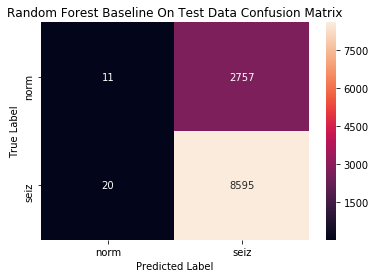

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
id002


Showing iteration %d 1
Out-of-bag score estimate: 0.636
Mean accuracy score: 0.587
F1 score: 0.002702702702702703
Recall: 0.0013656538067599864
Precision: 0.12903225806451613

 clasification report:
              precision    recall  f1-score   support

          0       0.59      0.99      0.74      8444
          1       0.13      0.00      0.00      5858

avg / total       0.40      0.59      0.44     14302


 confusion matrix:
 [[8390   54]
 [5850    8]]


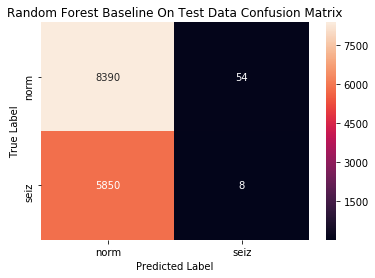

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
id008


Showing iteration %d 2
Out-of-bag score estimate: 0.837
Mean accuracy score: 0.552
F1 score: 0.7102076124567474
Recall: 0.7099005620406399
Precision: 0.7105149286023367

 clasification report:
              precision    recall  f1-score   support

          0       0.01      0.01      0.01       677
          1       0.71      0.71      0.71      2313

avg / total       0.55      0.55      0.55      2990


 confusion matrix:
 [[   8  669]
 [ 671 1642]]


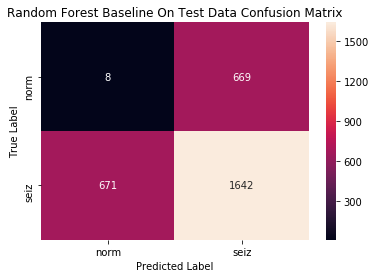

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
id010


Showing iteration %d 3
Out-of-bag score estimate: 0.842
Mean accuracy score: 0.674
F1 score: 0.805324459234609
Recall: 1.0
Precision: 0.6740947075208914

 clasification report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       585
          1       0.67      1.00      0.81      1210

avg / total       0.45      0.67      0.54      1795


 confusion matrix:
 [[   0  585]
 [   0 1210]]


/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


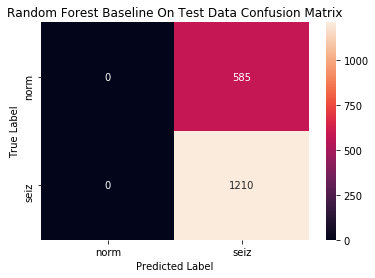

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
id011


Showing iteration %d 4
Out-of-bag score estimate: 0.790
Mean accuracy score: 0.986
F1 score: 0.992718616537142
Recall: 0.9997884642504583
Precision: 0.9857480533926585

 clasification report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       205
          1       0.99      1.00      0.99     14182

avg / total       0.97      0.99      0.98     14387


 confusion matrix:
 [[    0   205]
 [    3 14179]]


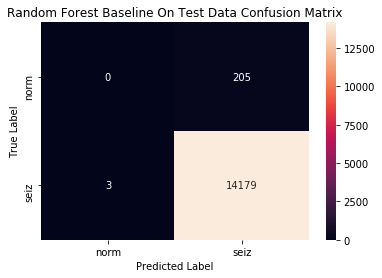

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
id012


Showing iteration %d 5
Out-of-bag score estimate: 0.843
Mean accuracy score: 0.765
F1 score: 0.8667614983404458
Recall: 1.0
Precision: 0.7648535564853557

 clasification report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       281
          1       0.76      1.00      0.87       914

avg / total       0.59      0.76      0.66      1195


 confusion matrix:
 [[  0 281]
 [  0 914]]


/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


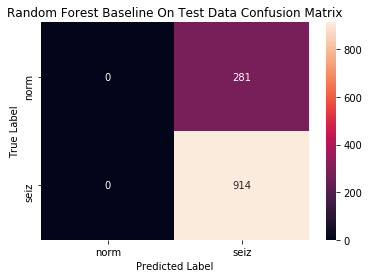

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
id013


Showing iteration %d 6
Out-of-bag score estimate: 0.840
Mean accuracy score: 0.872
F1 score: 0.9316048278945016
Recall: 1.0
Precision: 0.8719665271966527

 clasification report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       153
          1       0.87      1.00      0.93      1042

avg / total       0.76      0.87      0.81      1195


 confusion matrix:
 [[   0  153]
 [   0 1042]]


/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


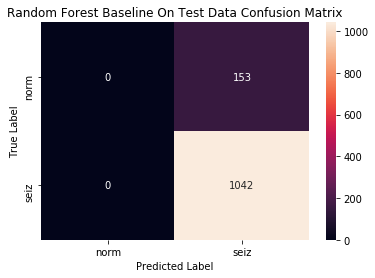

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)


IndexError: index 7 is out of bounds for axis 0 with size 7

In [40]:
%%time
for idx, batch in enumerate(datasplitter):
    X_train, y_train, X_test, y_test = batch 
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)
    
    # format the data correctly
#     classweight = sklearn.utils.compute_class_weight('balanced',
#                                                       np.unique(y_train).astype(int),
#                                                       y_train)
    model_params = {'max_depth': 5, 
                'n_estimators':100, 
                'max_features': 4,
                'oob_score': True,
               'random_state': randstate,
                'class_weight': 'balanced'}
    clf_rf = RandomForestClassifier(**model_params)

    res = clf_rf.fit(X_train, y_train)

    rf_test = clf_rf.predict(X_test)
    print('\n\nShowing iteration %d', idx)
    print('Out-of-bag score estimate: %.3f' % clf_rf.oob_score_)
    print('Mean accuracy score: %.3f' % accuracy_score(y_test, rf_test))
    print('F1 score:', f1_score(y_test, rf_test))
    print('Recall:', recall_score(y_test, rf_test))
    print('Precision:', precision_score(y_test, rf_test))
    print('\n clasification report:\n', classification_report(y_test, rf_test))
    print('\n confusion matrix:\n',confusion_matrix(y_test, rf_test))

    fig = plt.figure()
    cm = pd.DataFrame(confusion_matrix(y_test, rf_test), columns=['norm','seiz'], index=['norm','seiz'])
    sns.heatmap(cm, annot=True, fmt='g')
    ax = plt.gca()
    ax.set_title('Random Forest Baseline On Test Data Confusion Matrix')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.show()
    print(res)

id001


Showing iteration %d 0
Mean accuracy score: 0.752
F1 score: 0.12719975301018832
Recall: 0.07442196531791907
Precision: 0.43736730360934184

 clasification report:
              precision    recall  f1-score   support

          0       0.77      0.97      0.86      8615
          1       0.44      0.07      0.13      2768

avg / total       0.69      0.75      0.68     11383


 confusion matrix:
 [[8350  265]
 [2562  206]]


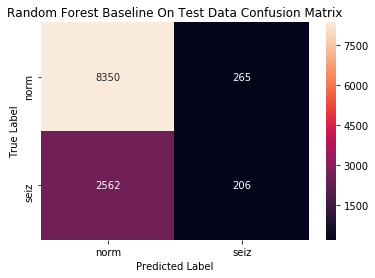

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
id002


In [ ]:
%%time
model_params = {
    'C': 10e4,
    'penalty': 'l1',
    'random_state': randstate,
    'class_weight': 'balanced'
}

for idx, batch in enumerate(datasplitter):
    X_train, y_train, X_test, y_test = batch 
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    clf_lr = LogisticRegression(**model_params)
    res = clf_lr.fit(X_train, y_train)

    rf_test = clf_lr.predict(X_test)
    print('\n\nShowing iteration %d', idx)
    print('Mean accuracy score: %.3f' % accuracy_score(y_test, rf_test))
    print('F1 score:', f1_score(y_test, rf_test))
    print('Recall:', recall_score(y_test, rf_test))
    print('Precision:', precision_score(y_test, rf_test))
    print('\n clasification report:\n', classification_report(y_test, rf_test))
    print('\n confusion matrix:\n',confusion_matrix(y_test, rf_test))

    fig = plt.figure()
    cm = pd.DataFrame(confusion_matrix(y_test, rf_test), columns=['norm','seiz'], index=['norm','seiz'])
    sns.heatmap(cm, annot=True, fmt='g')
    ax = plt.gca()
    ax.set_title('Random Forest Baseline On Test Data Confusion Matrix')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.show()
    print(res)

In [ ]:
# %%time
# res = clf.fit(X_train, y_train.ravel())
# print(res)

# 3) Test Models with SKLearn Summarizers

In [ ]:
lr_test = estimator.predict(Xdata)
ytrue = ydata

print('Out-of-bag score estimate: %.3f' % rf.oob_score_)
print('Mean accuracy score: %.3f' % accuracy_score(ytrue, lr_test))
print('F1 score:', f1_score(ytrue, lr_test))
print('Recall:', recall_score(ytrue, lr_test))
print('Precision:', precision_score(ytrue, lr_test))
print('\n clasification report:\n', classification_report(ytrue, lr_test))
print('\n confusion matrix:\n',confusion_matrix(ytrue, lr_test))

fig = plt.figure()
cm = pd.DataFrame(confusion_matrix(ytrue, lr_test), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True, fmt='g')
ax = plt.gca()
ax.set_title('Logistic Regression Baseline Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()